In [1]:
import gurobipy as gp
from gurobipy import GRB

# Time and demand settings
tau = 0.25
T = 60.0
N = int(T / tau)
D_EV = 36.0 #* tau
D_ICV = 36.0 #* tau

# Flow parameters
V = 900.0 #* tau
W = 450.0 #* tau
K = 0.12
Q_a = K * V * W / (V + W)

# Link lengths
length = {1: 0.0, 2: 900.0, 3: 1800.0, 4: 900.0, 5: 3600.0, 6: 900.0, 7: 0.0}
travelV = {a: int((length[a]/V)/tau + 1e-9) for a in length} #dividiamo per tau così invece che avere il tempo di percorrrenza abbiamo quanti step ci vogliono per percorrere
travelW = {a: int((length[a]/W)/tau + 1e-9) for a in length}

# Battery parameters
omega = 0.33
epsilon = 1.8e-4
B_max = 0.5
B0 = 0.35

# Budget constraint
I_budget = 2800.0

# Network topology
E = [1, 2, 3, 4, 5, 6, 7]
E_R, E_S, E_A = [1], [7], [2, 3, 4, 5, 6]
pred = {1: [], 2: [1], 3: [1], 4: [2], 5: [2], 6: [3, 4], 7: [5, 6]}
succ = {1: [2, 3], 2: [4, 5], 3: [6], 4: [6], 5: [7], 6: [7], 7: []}

# EV paths
paths = {0: [2, 4, 6], 1: [2, 5], 2: [3, 6]}
delta = {(a, p): int(a in paths[p]) for p in paths for a in E_A}
count_paths = {a: sum(delta[(a, p)] for p in paths) for a in E_A}

model = gp.Model("Dynamic_WCL")
model.setParam("OutputFlag", 0)

x = model.addVars(E_A, vtype=GRB.BINARY, name="x")
y = model.addVars(len(paths), vtype=GRB.BINARY, name="y")
B = {(a, p): model.addVar(ub=B_max, name=f"B_{a}_{p}") for p in paths for a in paths[p]}

classes = ['EV', 'ICV']
u, v, n, f = {}, {}, {}, {}
for m in classes:
    for a in E:
        for i in range(0, N+1):
            u[(m, a, i)] = model.addVar(lb=0.0)
            v[(m, a, i)] = model.addVar(lb=0.0)
            n[(m, a, i)] = model.addVar(lb=0.0)
        for b in pred[a]:
            for i in range(0, N+1):
                f[(m, b, a, i)] = model.addVar(lb=0.0)

alpha = model.addVars(E_A, classes, range(1, N+1), lb=0.0, ub=1.0, name="alpha")
for a in E_A:
    for i in range(1, N+1):
        model.addConstr(gp.quicksum(alpha[a, m, i] for m in classes) == 1.0)

# Corrected time-weighted objective function (Eq. 1)
#model.setObjective(gp.quicksum((T - (i - 1)*tau) *f[(m, b, 7, i)] for m in classes for b in pred[7] for i in range(1, N+1)), GRB.MAXIMIZE)

model.setObjective(gp.quicksum((N - i + 1) * f[(m, b, 7, i)] for m in classes for b in pred[7] for i in range(1, N+1)),GRB.MAXIMIZE)

#outflow_term = gp.quicksum((N - i + 1) * f[(m, b, 7, i)] for m in classes for b in pred[7] for i in range(1, N+1))
#internal_term = gp.quicksum((N - i + 1) * f[(m, b, a, i)] for m in classes for a in E_A if a != E_S for b in pred[a] for i in range(1, N+1))
#model.setObjective(outflow_term + 0.001 * internal_term, GRB.MAXIMIZE)

model.addConstr(gp.quicksum(length[a] * x[a] for a in E_A) <= I_budget)

#upper bound per v e u
#for a in E:
    #for i in range(0,N+1):
        #model.addConstr(gp.quicksum(v[(m,a,i)] for m in classes) <= 2*Q_a)
        


#M = 1e3 ## non cambia niente ma magari dà coerenza
M = B_max + omega * (3600 / V)
#constraints energetiche 4-6
for p, link_list in paths.items():
    for idx, a in enumerate(link_list):
        prevB = B0 if idx == 0 else B[(link_list[idx - 1], p)]
        recharge = omega * (length[a] / V)
        consume = epsilon * length[a]
        model.addConstr(B[(a, p)] <= B_max)
        model.addConstr(B[(a, p)] <= prevB - consume + recharge * x[a] + M * (1 - y[p]))
        model.addConstr(B[(a, p)] >= prevB - consume + recharge * x[a] - M * (1 - y[p]))
        model.addConstr(M* (y[p]-1)<=B[(a,p)] )
        


#15 e 18
for i in range(0, N+1):
    model.addConstr(u[('EV', 1, i)] == D_EV)
    model.addConstr(u[('ICV', 1, i)] == D_ICV)
    model.addConstr(v[('EV', 7, i)] == 0)
    model.addConstr(v[('ICV', 7, i)] == 0)
#16 e 17
for m in classes:
    for a in E:
        for i in range(0, N+1):
            if a not in E_R:
                model.addConstr(u[(m, a, i)]- gp.quicksum(f[(m, b, a, i)] for b in pred[a])==0 )
            if a not in E_S:
                model.addConstr(v[(m, a, i)] - gp.quicksum(f[(m, a, b, i)] for b in succ[a])== 0)
#13 e 14
for m in classes:
    for a in E:
        for i in range(0, N+1):
            inflow = gp.quicksum(u[(m, a, k)] for k in range(0, i+1))  # 12
            outflow = gp.quicksum(v[(m, a, k)] for k in range(0, i+1))
            model.addConstr(n[(m, a, i)]- inflow + outflow==0)
            if a in E_A:
                if i >= travelV[a]:
                    model.addConstr(gp.quicksum(u[(m, a, k)] for k in range(i - travelV[a] + 1, i+1))- n[(m, a, i)]<=0 )

                if i >= travelW[a]:
                    model.addConstr(n[(m, a, i)] + gp.quicksum(v[(m, a, k)] for k in range(i - travelW[a] + 1, i+1)) <= K * length[a] * alpha[a, m, i])
                    #model.addConstr(gp.quicksum(n[(m, a, i)] for m in classes) + gp.quicksum(v[(m, a, k)] for m in classes for k in range(i - travelW[a] + 1, i+1))<= (K * length[a]*alpha[a,m,i]))
#for a in E_A:
   # for m in classes:
        #for i in range(1, N+1):
          #  model.addConstr(n[(m, a, i)] <= K * length[a] * alpha[a, m, i], name=f"cap_consistency_{a}_{m}_{i}")

#20-23
for a in E_A:
    for i in range(0, N+1):
        inflow_s = gp.quicksum(u[(m, a, k)] for m in classes for k in range(0, i))
        outflow_s = gp.quicksum(v[(m, a, k)] for m in classes for k in range(0, i - travelW[a] + 1)) if i > travelW[a] else 0
        supply = K * length[a] + outflow_s - inflow_s
        model.addConstr(gp.quicksum(u[(m, a, i)] for m in classes) <= Q_a)
        model.addConstr(gp.quicksum(u[(m, a, i)] for m in classes) <= supply)

        inflow_d = gp.quicksum(v[(m, a, k)] for m in classes for k in range(0, i))
        outflow_d = gp.quicksum(u[(m, a, k)] for m in classes for k in range(0, i - travelV[a] + 1)) if i > travelV[a] else 0
        demand = outflow_d - inflow_d
        model.addConstr(gp.quicksum(v[(m, a, i)] for m in classes) <= Q_a)
        model.addConstr(gp.quicksum(v[(m, a, i)] for m in classes) <= demand)
#19
for m in classes:
    for a in E_A:
        for i in range(0, N+1):
            inflow = gp.quicksum(f[(m, b, a, i)] for b in pred[a])
            if m == 'EV':
                model.addConstr(inflow <= Q_a * gp.quicksum(delta[(a, p)] * y[p] for p in paths))
            else:
                model.addConstr(inflow <= Q_a * count_paths[a])
#for i in range(N+1):
    #model.addConstr(gp.quicksum(f[(m, b, 7, i)] for m in classes for b in pred[7]) <= Q_a, name=f"cap_inflow_7_{i}")

#paths_through_a = {a: [p for p in paths if a in paths[p]] for a in E_A}
# {2: [0, 1], 3: [2], 4: [0], 5: [1], 6: [0, 2]}
#for a in E_A:
 #   for i in range(1, N+1):
 #       model.addConstr(alpha[a, "EV", i] <= gp.quicksum(y[p] for p in paths_through_a[a]))
for a in E_A: ##senza definire nuove cose è uguale a quello sopra
    for i in range(1, N+1):
        model.addConstr(alpha[a, "EV", i] <= gp.quicksum(y[p] for p in paths if delta[(a, p)] == 1))

model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06


In [2]:
# === Output: WCL installation and EV path choices ===
if model.status == GRB.OPTIMAL or model.status == GRB.SUBOPTIMAL:
    print(f"🎯 Valore funzione obiettivo (outflow pesato): {model.ObjVal:.2f}")
    for p in paths:
         for a in paths[p]:
            if B[(a,p)].x > 1e-4:
                 print(f"energia B[({a},{p})]={B[(a,p)]}")
    
    print("🔌 Link selezionati per l'installazione delle WCL:")
    for a in E_A:
        if x[a].x > 0.5:
            print(f"  - Link {a} (lunghezza: {length[a]} m)")

    print("🚗 Percorsi selezionati per EV:")
    for p in paths:
        if y[p].x > 0.5:
            print(f"  - Path {p}: 1 -> " + " -> ".join(str(a) for a in paths[p]) + " -> 7")
else:
    print("⚠️ Nessuna soluzione ottima trovata.")



🎯 Valore funzione obiettivo (outflow pesato): 471960.00
energia B[(2,0)]=<gurobi.Var B_2_0 (value 0.18799999999999994)>
energia B[(4,0)]=<gurobi.Var B_4_0 (value 0.026000000000000023)>
energia B[(6,0)]=<gurobi.Var B_6_0 (value 0.19400000000000012)>
energia B[(3,2)]=<gurobi.Var B_3_2 (value 0.026000000000000023)>
energia B[(6,2)]=<gurobi.Var B_6_2 (value 0.19400000000000012)>
🔌 Link selezionati per l'installazione delle WCL:
  - Link 6 (lunghezza: 900.0 m)
🚗 Percorsi selezionati per EV:
  - Path 0: 1 -> 2 -> 4 -> 6 -> 7
  - Path 2: 1 -> 3 -> 6 -> 7


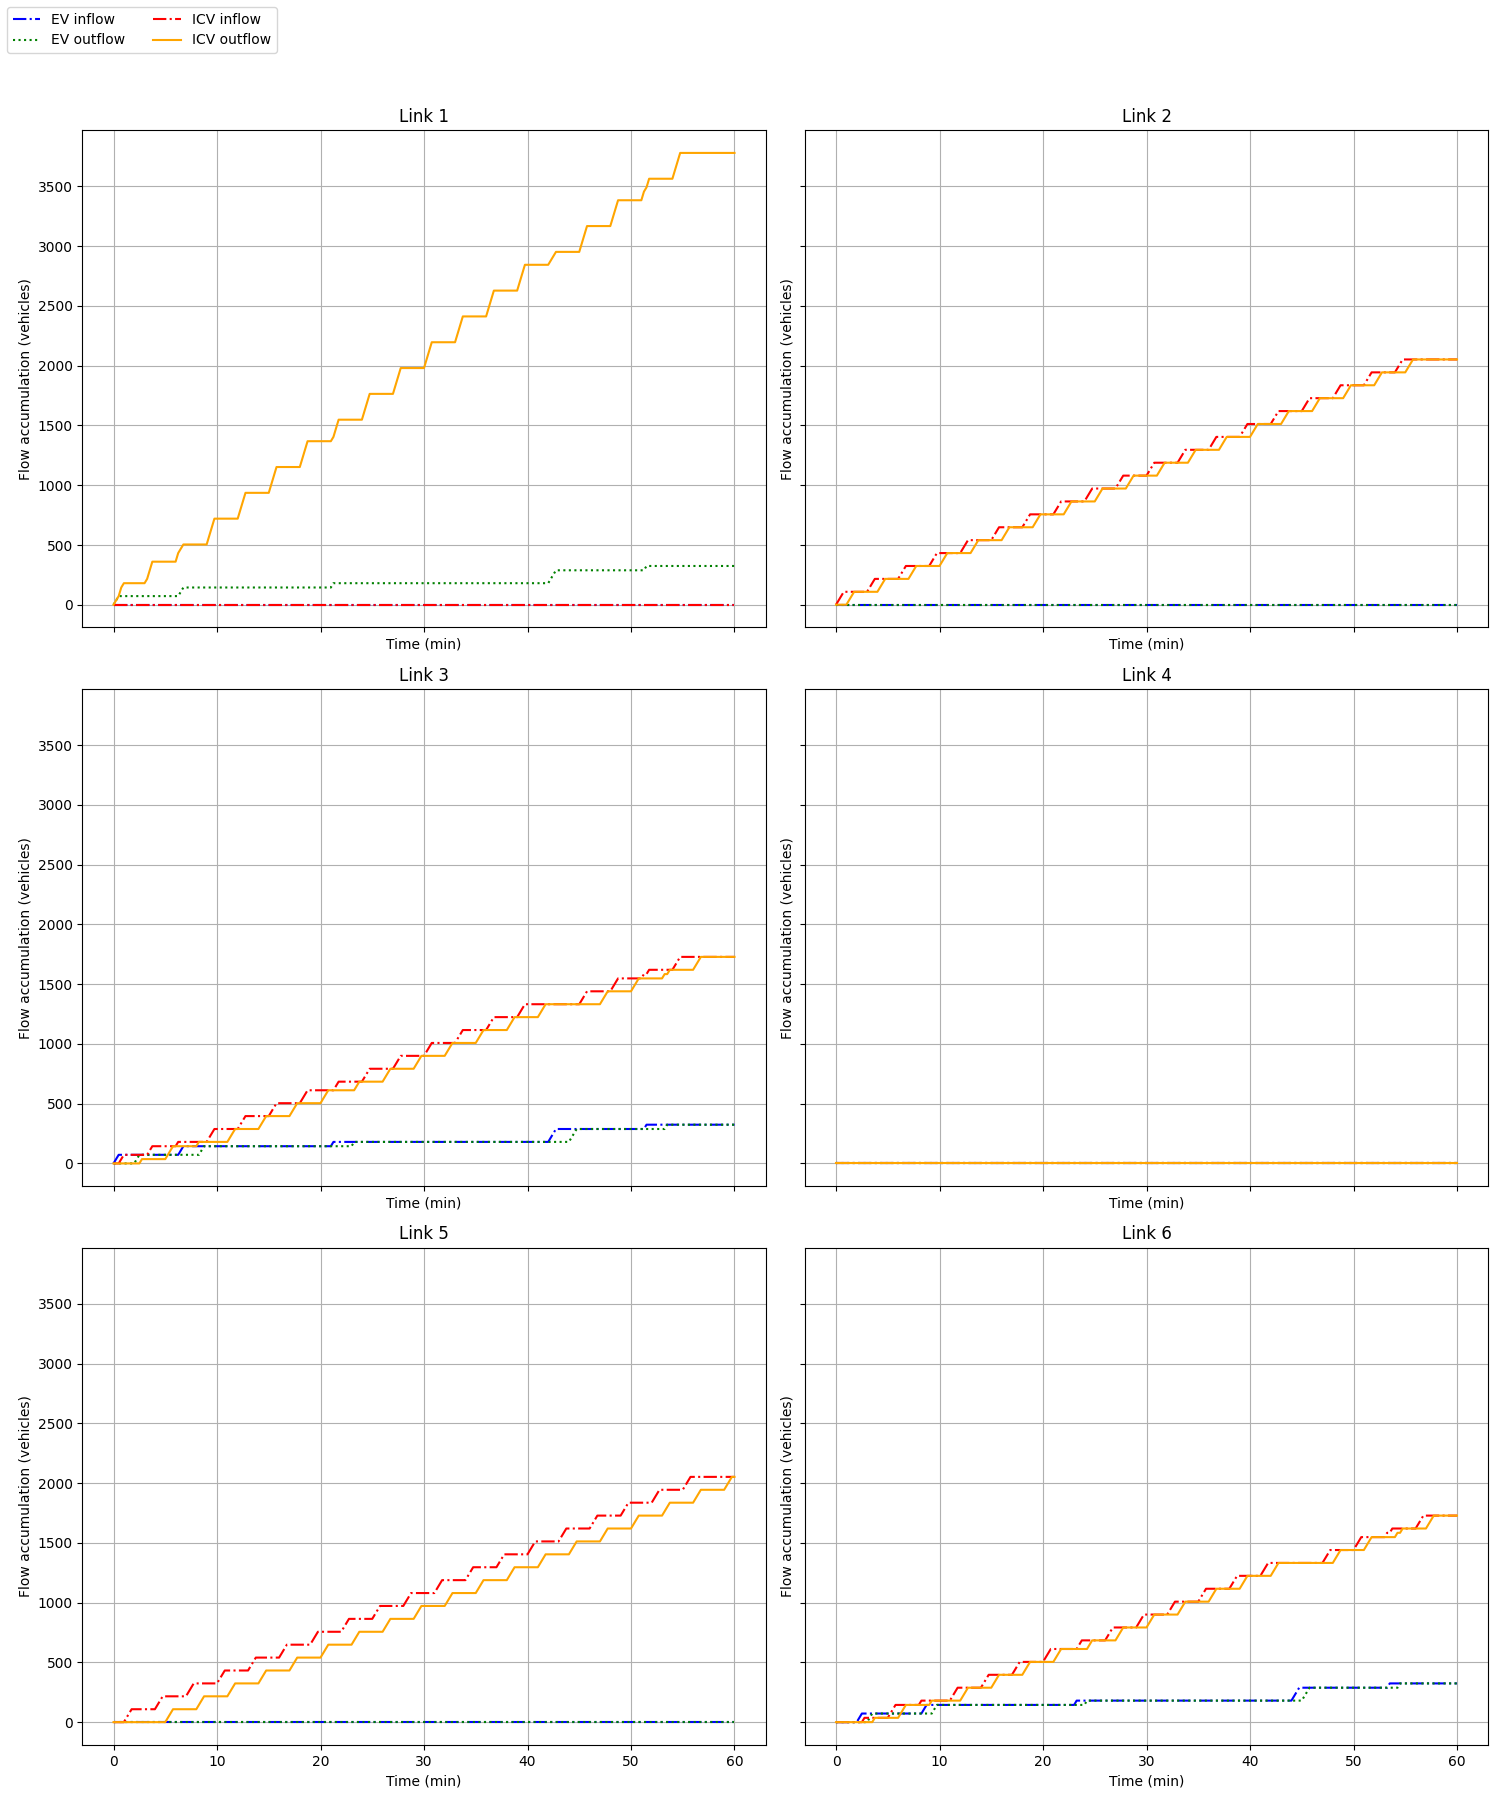

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x_time = [i * tau for i in range(N+1)]

def cumulative_series(values):
    return np.cumsum(values)

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18), sharex=True, sharey=True)
axes = axes.flatten()

for idx, a in enumerate(E[:-1]):
    ax = axes[idx]

    EV_inflow = [sum(f[("EV", b, a, i)].X for b in pred[a]) for i in range(N+1)]
    EV_outflow = [sum(f[("EV", a, b, i)].X for b in succ[a]) for i in range(N+1)]
    ICV_inflow = [sum(f[("ICV", b, a, i)].X for b in pred[a]) for i in range(N+1)]
    ICV_outflow = [sum(f[("ICV", a, b, i)].X for b in succ[a]) for i in range(N+1)]

    ax.plot(x_time, cumulative_series(EV_inflow), label="EV inflow", linestyle='dashdot', color='blue')
    ax.plot(x_time, cumulative_series(EV_outflow), label="EV outflow", linestyle='dotted', color='green')
    ax.plot(x_time, cumulative_series(ICV_inflow), label="ICV inflow", linestyle='dashdot', color='red')
    ax.plot(x_time, cumulative_series(ICV_outflow), label="ICV outflow", linestyle='solid', color='orange')

    ax.set_title(f"Link {a}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Flow accumulation (vehicles)")
    ax.grid(True)

# Nasconde i plot extra se E_A ha meno di 6 link
for j in range(len(E), len(axes)):
    fig.delaxes(axes[j])

# Una sola legenda comune
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='upper left')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [37]:
for i in range(N+1):
    print(f"t={i*tau:.2f}, outflow 7 =", sum(f[(m,b,7,i)].X for m in classes for b in pred[7]))


t=0.00, outflow 7 = 0.0
t=0.25, outflow 7 = 0.0
t=0.50, outflow 7 = 0.0
t=0.75, outflow 7 = 0.0
t=1.00, outflow 7 = 0.0
t=1.25, outflow 7 = 0.0
t=1.50, outflow 7 = 0.0
t=1.75, outflow 7 = 0.0
t=2.00, outflow 7 = 0.0
t=2.25, outflow 7 = 0.0
t=2.50, outflow 7 = 0.0
t=2.75, outflow 7 = 0.0
t=3.00, outflow 7 = 0.0
t=3.25, outflow 7 = 36.0
t=3.50, outflow 7 = 36.0
t=3.75, outflow 7 = 36.0
t=4.00, outflow 7 = 0.0
t=4.25, outflow 7 = 0.0
t=4.50, outflow 7 = 0.0
t=4.75, outflow 7 = 0.0
t=5.00, outflow 7 = 0.0
t=5.25, outflow 7 = 36.0
t=5.50, outflow 7 = 36.0
t=5.75, outflow 7 = 36.0
t=6.00, outflow 7 = 0.0
t=6.25, outflow 7 = 36.0
t=6.50, outflow 7 = 36.0
t=6.75, outflow 7 = 36.0
t=7.00, outflow 7 = 0.0
t=7.25, outflow 7 = 0.0
t=7.50, outflow 7 = 0.0
t=7.75, outflow 7 = 0.0
t=8.00, outflow 7 = 0.0
t=8.25, outflow 7 = 36.0
t=8.50, outflow 7 = 36.0
t=8.75, outflow 7 = 36.0
t=9.00, outflow 7 = 0.0
t=9.25, outflow 7 = 36.0
t=9.50, outflow 7 = 36.0
t=9.75, outflow 7 = 36.0
t=10.00, outflow 7 = 0.0


In [26]:
for m in classes:
    for a in E_A:
        for i in range(1,N+1):
            print(alpha[a,m,i])

<gurobi.Var alpha[2,EV,1] (value 1.0)>
<gurobi.Var alpha[2,EV,2] (value 1.0)>
<gurobi.Var alpha[2,EV,3] (value 1.0)>
<gurobi.Var alpha[2,EV,4] (value 1.0)>
<gurobi.Var alpha[2,EV,5] (value 1.0)>
<gurobi.Var alpha[2,EV,6] (value 1.0)>
<gurobi.Var alpha[2,EV,7] (value 1.0)>
<gurobi.Var alpha[2,EV,8] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,9] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,10] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,11] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,12] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,13] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,14] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,15] (value 0.0)>
<gurobi.Var alpha[2,EV,16] (value 0.0)>
<gurobi.Var alpha[2,EV,17] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,18] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,19] (value 1.1102230246251565e-16)>
<gurobi.Var alpha[2,EV,20] (value 1.1102230246251565e-16)>


In [167]:
total_travel_time = 0.0
for m in classes:
    for a in E:
        for i in range(N+1):
            total_travel_time += n[(m, a, i)].X * tau

print(f"Total Travel Time (EV + ICV): {total_travel_time:.2f} vehicle-minutes")


Total Travel Time (EV + ICV): 524898.00 vehicle-minutes


In [27]:
# Archi più usati nei path EV
critical_arcs = sorted(count_paths.keys(), key=lambda a: -count_paths[a])[:3]  # i 3 archi più frequentati
critical_paths = list(paths.keys())  # tutti i path EV
print("\n🛣️ FLOW AND OCCUPANCY CHECK")
for a in critical_arcs:
    print(f"\n-- Link {a} (length = {length[a]} m) --")
    print(f"  WCL installed: {x[a].X > 0.5}")
    for m in classes:
        print(f"  Class {m}:")
        for i in range(N+1):
            u_val = u[(m, a, i)].X
            v_val = v[(m, a, i)].X
            n_val = n[(m, a, i)].X
            if u_val + v_val + n_val > 0.001:  # evita stampa vuota
                print(f"    t={i*tau:5.2f} min: u={u_val:6.2f}, v={v_val:6.2f}, n={n_val:6.2f}")



🛣️ FLOW AND OCCUPANCY CHECK

-- Link 2 (length = 900.0 m) --
  WCL installed: False
  Class EV:
  Class ICV:
    t= 0.25 min: u= 36.00, v=  0.00, n= 36.00
    t= 0.50 min: u= 36.00, v=  0.00, n= 72.00
    t= 0.75 min: u= 36.00, v=  0.00, n=108.00
    t= 1.00 min: u=  0.00, v=  0.00, n=108.00
    t= 1.25 min: u=  0.00, v= 36.00, n= 72.00
    t= 1.50 min: u=  0.00, v= 36.00, n= 36.00
    t= 1.75 min: u=  0.00, v= 36.00, n=  0.00
    t= 3.25 min: u= 36.00, v=  0.00, n= 36.00
    t= 3.50 min: u= 36.00, v=  0.00, n= 72.00
    t= 3.75 min: u= 36.00, v=  0.00, n=108.00
    t= 4.00 min: u=  0.00, v=  0.00, n=108.00
    t= 4.25 min: u=  0.00, v= 36.00, n= 72.00
    t= 4.50 min: u=  0.00, v= 36.00, n= 36.00
    t= 4.75 min: u=  0.00, v= 36.00, n=  0.00
    t= 6.25 min: u= 36.00, v=  0.00, n= 36.00
    t= 6.50 min: u= 36.00, v=  0.00, n= 72.00
    t= 6.75 min: u= 36.00, v=  0.00, n=108.00
    t= 7.00 min: u=  0.00, v=  0.00, n=108.00
    t= 7.25 min: u=  0.00, v= 36.00, n= 72.00
    t= 7.50 min:

In [169]:
print("\n🔁 LINK FLOW DETAILS (f)")
for a in critical_arcs:
    for m in classes:
        for b in pred[a]:
            for i in range(N+1):
                val = f[(m, b, a, i)].X
                if val > 0.001:
                    print(f"f[{m},{b}->{a},{i*tau:.2f}] = {val:.2f}")
        for b in succ[a]:
            for i in range(N+1):
                val = f[(m, a, b, i)].X
                if val > 0.001:
                    print(f"f[{m},{a}->{b},{i*tau:.2f}] = {val:.2f}")



🔁 LINK FLOW DETAILS (f)
f[ICV,1->2,0.00] = 36.00
f[ICV,1->2,0.50] = 36.00
f[ICV,1->2,0.75] = 36.00
f[ICV,1->2,3.25] = 36.00
f[ICV,1->2,3.50] = 36.00
f[ICV,1->2,3.75] = 36.00
f[ICV,1->2,6.25] = 36.00
f[ICV,1->2,6.50] = 36.00
f[ICV,1->2,6.75] = 36.00
f[ICV,1->2,9.25] = 36.00
f[ICV,1->2,9.50] = 36.00
f[ICV,1->2,9.75] = 36.00
f[ICV,1->2,12.25] = 36.00
f[ICV,1->2,12.50] = 36.00
f[ICV,1->2,12.75] = 36.00
f[ICV,1->2,15.25] = 36.00
f[ICV,1->2,15.50] = 36.00
f[ICV,1->2,15.75] = 36.00
f[ICV,1->2,18.25] = 36.00
f[ICV,1->2,18.50] = 36.00
f[ICV,1->2,18.75] = 36.00
f[ICV,1->2,21.25] = 36.00
f[ICV,1->2,21.50] = 36.00
f[ICV,1->2,21.75] = 36.00
f[ICV,1->2,24.25] = 36.00
f[ICV,1->2,24.50] = 36.00
f[ICV,1->2,24.75] = 36.00
f[ICV,1->2,27.25] = 36.00
f[ICV,1->2,27.50] = 36.00
f[ICV,1->2,27.75] = 36.00
f[ICV,1->2,30.25] = 36.00
f[ICV,1->2,30.50] = 36.00
f[ICV,1->2,30.75] = 36.00
f[ICV,1->2,33.25] = 36.00
f[ICV,1->2,33.50] = 36.00
f[ICV,1->2,33.75] = 36.00
f[ICV,1->2,36.25] = 36.00
f[ICV,1->2,36.50] = 36.00

In [170]:
for i in range(N+1):
    used = sum(f[(m, b, 7, i)].X for m in classes for b in pred[7])
    if used > 0.95 * Q_a:
        print(f"Node 7 saturated at t={i*tau:.2f} with flow {used:.2f}")


Node 7 saturated at t=3.25 with flow 36.00
Node 7 saturated at t=3.50 with flow 36.00
Node 7 saturated at t=3.75 with flow 36.00
Node 7 saturated at t=5.25 with flow 36.00
Node 7 saturated at t=5.50 with flow 36.00
Node 7 saturated at t=5.75 with flow 36.00
Node 7 saturated at t=6.25 with flow 36.00
Node 7 saturated at t=6.50 with flow 36.00
Node 7 saturated at t=6.75 with flow 36.00
Node 7 saturated at t=8.25 with flow 36.00
Node 7 saturated at t=8.50 with flow 36.00
Node 7 saturated at t=8.75 with flow 36.00
Node 7 saturated at t=9.25 with flow 36.00
Node 7 saturated at t=9.50 with flow 36.00
Node 7 saturated at t=9.75 with flow 36.00
Node 7 saturated at t=11.25 with flow 36.00
Node 7 saturated at t=11.50 with flow 36.00
Node 7 saturated at t=11.75 with flow 36.00
Node 7 saturated at t=12.25 with flow 36.00
Node 7 saturated at t=12.50 with flow 36.00
Node 7 saturated at t=12.75 with flow 36.00
Node 7 saturated at t=14.25 with flow 36.00
Node 7 saturated at t=14.50 with flow 36.00
Nod

In [171]:
print("\n🔍 OCCUPAZIONE MAX NEGLI ARCHI")
for a in E_A:
    max_n = max(n[(m, a, i)].X for m in classes for i in range(N+1))
    capacity = K * length[a]
    print(f"Link {a}: Max n = {max_n:.2f} vs Capacity = {capacity:.2f} ({(max_n / capacity) * 100:.1f}%)")



🔍 OCCUPAZIONE MAX NEGLI ARCHI
Link 2: Max n = 108.00 vs Capacity = 108.00 (100.0%)
Link 3: Max n = 108.00 vs Capacity = 216.00 (50.0%)
Link 4: Max n = 0.00 vs Capacity = 108.00 (0.0%)
Link 5: Max n = 216.00 vs Capacity = 432.00 (50.0%)
Link 6: Max n = 108.00 vs Capacity = 108.00 (100.0%)


In [172]:
print("\n📥 FLUSSO INGRESSO massimo per link")
for a in E_A:
    max_u = max(sum(u[(m, a, i)].X for m in classes) for i in range(N+1))
    print(f"Link {a}: Max u = {max_u:.2f} vs Q_a = {Q_a:.2f}")



📥 FLUSSO INGRESSO massimo per link
Link 2: Max u = 36.00 vs Q_a = 36.00
Link 3: Max u = 36.00 vs Q_a = 36.00
Link 4: Max u = 0.00 vs Q_a = 36.00
Link 5: Max u = 36.00 vs Q_a = 36.00
Link 6: Max u = 36.00 vs Q_a = 36.00


In [ ]:
print("\n=== DIAGNOSTICA LINK 4 ===")

print("\n--- Decisori ---")
print(f"x[4] = {x[4].X:.2f}  (WCL installato?)")
print(f"count_paths[4] = {count_paths[4]}  (#path che contengono 4)")

print("\n--- Path feasibility e stato batteria (solo per EV) ---")
for p in paths:
    if 4 in paths[p]:
        print(f"\nPath {p} contiene link 4")
        print(f"  y[{p}] = {y[p].X:.2f}")
        for a in paths[p]:
            print(f"    B[{a}, {p}] = {B[(a,p)].X:.3f}")

print("\n--- Alpha[a=4, m, i] ---")
for i in range(N+1):
    alpha_ev = alpha[4, 'EV', i].X
    alpha_icv = alpha[4, 'ICV', i].X
    if alpha_ev > 1e-4 or alpha_icv > 1e-4:
        print(f"t={i:02d} | alpha[EV]={alpha_ev:.2f} | alpha[ICV]={alpha_icv:.2f}")

print("\n--- Flussi f (ICV e EV) da 2 a 4 ---")
for i in range(N+1):
    f_ev = f[('EV', 2, 4, i)].X
    f_icv = f[('ICV', 2, 4, i)].X
    if f_ev > 1e-3 or f_icv > 1e-3:
        print(f"t={i:02d} | f[EV,2→4] = {f_ev:.2f} | f[ICV,2→4] = {f_icv:.2f}")

print("\n--- Densità e outflow sul link 4 ---")
for i in range(N+1):
    n_ev = n[('EV', 4, i)].X
    n_icv = n[('ICV', 4, i)].X
    v_ev = v[('EV', 4, i)].X
    v_icv = v[('ICV', 4, i)].X
    if n_ev > 1e-3 or n_icv > 1e-3 or v_ev > 1e-3 or v_icv > 1e-3:
        print(f"t={i:02d} | n[EV]={n_ev:.2f}, v[EV]={v_ev:.2f} | n[ICV]={n_icv:.2f}, v[ICV]={v_icv:.2f}")

print("\n--- Contributi upstream/downstream ---")
for i in range(N+1):
    u_ev = u[('EV', 4, i)].X
    u_icv = u[('ICV', 4, i)].X
    if u_ev > 1e-3 or u_icv > 1e-3:
        print(f"t={i:02d} | u[EV,4] = {u_ev:.2f} | u[ICV,4] = {u_icv:.2f}")



=== DIAGNOSTICA LINK 4 ===

--- Decisori ---
x[4] = -0.00  (WCL installato?)
count_paths[4] = 1  (#path che contengono 4)

--- Path feasibility e stato batteria (solo per EV) ---

Path 0 contiene link 4
  y[0] = 1.00
    B[2, 0] = 0.188
    B[4, 0] = 0.026
    B[6, 0] = 0.194

--- Alpha[a=4, m, i] ---


KeyError: (0, 'EV', 0)